In [1]:
import azureml.core
import pandas as pd
from azureml.core.workspace import Workspace
from azureml.train.automl.run import AutoMLRun
import time
import logging
from sklearn import datasets
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import random
import numpy as np

import os
import pandas as pd
import numpy as np
import json
import requests
import joblib
from sklearn.metrics import confusion_matrix
import itertools

from azureml.core import Dataset, Workspace, Experiment
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.widgets import RunDetails
from azureml.train.automl import AutoMLConfig

from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice, Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

In [10]:
# from azureml.core import Workspace
# ws = Workspace.create(name='mymlworkspace',
#                       subscription_id='1e30ba0a-66fa-4479-9bca-95ba2cf71b20',    
#                       resource_group='mymlexp',
#                       create_resource_group=False,
#                       location='eastus2' # or other supported Azure region  
#                      )
ws = Workspace.from_config()

experiment_name = 'automl-experiment-2'

project_folder = './'

experiment = Experiment(ws, experiment_name)

In [3]:
ws.get_details()

{'id': '/subscriptions/f9d5a085-54dc-4215-9ba6-dad5d86e60a0/resourceGroups/aml-quickstarts-133730/providers/Microsoft.MachineLearningServices/workspaces/quick-starts-ws-133730',
 'name': 'quick-starts-ws-133730',
 'location': 'southcentralus',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'sku': 'Basic',
 'workspaceid': '92a2fef2-89f9-47aa-9b17-bf1c5455be01',
 'sdkTelemetryAppInsightsKey': 'd83d49eb-3973-4a30-937a-eb3fc2d37c24',
 'description': '',
 'friendlyName': '',
 'creationTime': '2021-01-06T23:03:21.0389300+00:00',
 'containerRegistry': '/subscriptions/f9d5a085-54dc-4215-9ba6-dad5d86e60a0/resourceGroups/aml-quickstarts-133730/providers/Microsoft.ContainerRegistry/registries/92a2fef289f947aa9b17bf1c5455be01',
 'keyVault': '/subscriptions/f9d5a085-54dc-4215-9ba6-dad5d86e60a0/resourcegroups/aml-quickstarts-133730/providers/microsoft.keyvault/vaults/mlkeyvault133730',
 'applicationInsights': '/subscriptions/f9d5a085-54dc-4215-9ba6-dad5d86e60a0/resourcegroups/aml-quicksta

In [ ]:
# Create the configuration file.
#ws.write_config()

# Use this code to load the workspace from 
# other scripts and notebooks in this directory.
# ws = Workspace.from_config()

In [4]:
# ws = Workspace.from_config()
# # choose a name for the run history container in the workspace
# experiment_name = 'automl-classifier'
# # project folder

import os

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data=output, index=['']).T

,
SDK version,1.19.0
Subscription ID,f9d5a085-54dc-4215-9ba6-dad5d86e60a0
Workspace,quick-starts-ws-133730
Resource Group,aml-quickstarts-133730
Location,southcentralus
Project Directory,./


In [5]:
cpu_cluster_name = "AUTOML-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D12_V2',
                                                           max_nodes=5)
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [6]:
# Method 1 of importing dataset
from sklearn import datasets

digits = datasets.load_digits()

# Exclude the first 100 rows from training so that they can be used for test.
X_train = digits.data[100:,:]
y_train = digits.target[100:]

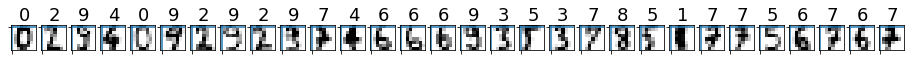

In [7]:
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 2, y = -2, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(8, 8), cmap = plt.cm.Greys)
plt.show()

In [ ]:
###############################################################Didn't worked#################################################
# # make sure utils.py is in the same directory as this code
# from utils import load_data
# import glob


# # note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
# X_train = load_data(glob.glob(os.path.join(data_folder,"**/train-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
# X_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
# y_train = load_data(glob.glob(os.path.join(data_folder,"**/train-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)
# y_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)


# # now let's show some randomly chosen images from the traininng set.
# count = 0
# sample_size = 30
# plt.figure(figsize=(16, 6))
# for i in np.random.permutation(X_train.shape[0])[:sample_size]:
#     count = count + 1
#     plt.subplot(1, sample_size, count)
#     plt.axhline('')
#     plt.axvline('')
#     plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
#     plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
# plt.show()

In [ ]:
# dataset = Dataset.get_by_name(ws, 'mnist_opendataset')
# dataset.take(5).to_pandas_dataframe()
# data_train, data_test = dataset.random_split(0.9)

In [8]:
# Method 2 of importing dataset
from sklearn import datasets
from azureml.core.dataset import Dataset
from scipy import sparse
import numpy as np
import pandas as pd
import os

# Create a project_folder if it doesn't exist
if not os.path.isdir('data'):
    os.mkdir('data')
    
if not os.path.exists('project_folder'):
    os.makedirs('project_folder')

X = pd.DataFrame(digits.data[100:,:])
y = pd.DataFrame(digits.target[100:])

# merge X and y
label = "digit"
X[label] = y

training_data = X

training_data.to_csv('data/digits.csv')
ds = ws.get_default_datastore()
ds.upload(src_dir='./data', target_path='digitsdata', overwrite=True, show_progress=True)

training_data = Dataset.Tabular.from_delimited_files(path=ds.path('digitsdata/digits.csv'))
dataset = Dataset.Tabular.from_delimited_files(example_data)


Uploading an estimated of 1 files
Uploading ./data/digits.csv
Uploaded ./data/digits.csv, 1 files out of an estimated total of 1
Uploaded 1 files


In [26]:
mnist_data = training_data.register(workspace=ws,
                                 name='mnist_data',
                                 description='mnist training data')

In [34]:
mnist_data

{
  "source": [
    "('workspaceblobstore', 'digitsdata/digits.csv')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes"
  ],
  "registration": {
    "id": "7c8c8dcd-fdab-4691-8255-82bf741738b0",
    "name": "mnist_data",
    "version": 1,
    "description": "mnist training data",
    "workspace": "Workspace.create(name='quick-starts-ws-133730', subscription_id='f9d5a085-54dc-4215-9ba6-dad5d86e60a0', resource_group='aml-quickstarts-133730')"
  }
}

In [27]:
from azureml.core import Dataset, Run
dataset = Dataset.get_by_name(ws, 'mnist_data')

# load the TabularDataset to pandas DataFrame
df = dataset.to_pandas_dataframe()

In [33]:
dataset

{
  "source": [
    "('workspaceblobstore', 'digitsdata/digits.csv')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes"
  ],
  "registration": {
    "id": "7c8c8dcd-fdab-4691-8255-82bf741738b0",
    "name": "mnist_data",
    "version": 1,
    "description": "mnist training data",
    "workspace": "Workspace.create(name='quick-starts-ws-133730', subscription_id='f9d5a085-54dc-4215-9ba6-dad5d86e60a0', resource_group='aml-quickstarts-133730')"
  }
}

In [35]:
from azureml.train.automl import AutoMLConfig
import time
import logging

automl_settings = {
    "name": "AutoML_Demo_Experiment_{0}".format(time.time()),
    "experiment_timeout_minutes" : 20,
    "enable_early_stopping" : True,
    "iteration_timeout_minutes": 10,
    "n_cross_validations": 5,
    "primary_metric": 'AUC_weighted',
    "max_concurrent_iterations": 10,
}

automl_config = AutoMLConfig(task='classification',
                             debug_log='automl_errors.log',
                             path=project_folder,
                             compute_target=compute_target,
                             training_data=mnist_data,
                             label_column_name=label,
                             **automl_settings,
                             )

In [ ]:
# from azureml.train.automl import AutoMLConfig

# ##Local compute 
# Automl_config = AutoMLConfig(task = 'classification',
#                              primary_metric = 'AUC_weighted',
#                              max_time_sec = 12000,
#                              iterations = 20,
#                              compute_target=compute_target,
#                              n_cross_validations = 3,
#                              exit_score = 0.9985,
#                              blacklist_algos = ['kNN','LinearSVM'],
#                              X = X_train,
#                              y = y_train,
#                              path=project_folder)

In [36]:
from azureml.core.experiment import Experiment
experiment=Experiment(ws, "test_experiment")
# local_run = experiment.submit(Automl_config, show_output=True)
remote_run = experiment.submit(automl_config, show_output=True)

Running on remote.
No run_configuration provided, running on AUTOML-cluster with default configuration
Running on remote compute: AUTOML-cluster
Parent Run ID: AutoML_586039ac-38a2-42d9-ba8c-53d32334be73

Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing val

In [ ]:
# from azureml.train.widgets import RunDetails
# RunDetails(local_run).show()

In [37]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [38]:
children = list(remote_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

import pandas as pd
rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
average_precision_score_macro,1.00,0.99,0.93,0.96,0.97,0.92,0.97,0.86,0.96,0.99,...,nan,nan,nan,nan,nan,nan,nan,nan,1.00,1.00
precision_score_weighted,0.97,0.97,0.86,0.92,0.93,0.87,0.93,0.80,0.91,0.97,...,nan,nan,nan,nan,nan,nan,nan,nan,0.99,0.99
recall_score_weighted,0.97,0.97,0.86,0.91,0.93,0.87,0.93,0.78,0.91,0.97,...,nan,nan,nan,nan,nan,nan,nan,nan,0.99,0.99
precision_score_micro,0.97,0.97,0.86,0.91,0.93,0.87,0.93,0.78,0.91,0.97,...,nan,nan,nan,nan,nan,nan,nan,nan,0.99,0.99
f1_score_macro,0.97,0.97,0.85,0.91,0.93,0.86,0.92,0.77,0.91,0.96,...,nan,nan,nan,nan,nan,nan,nan,nan,0.99,0.99
precision_score_macro,0.97,0.97,0.86,0.91,0.93,0.87,0.93,0.79,0.91,0.96,...,nan,nan,nan,nan,nan,nan,nan,nan,0.99,0.99
accuracy,0.97,0.97,0.86,0.91,0.93,0.87,0.93,0.78,0.91,0.97,...,nan,nan,nan,nan,nan,nan,nan,nan,0.99,0.99
average_precision_score_micro,1.00,0.99,0.93,0.96,0.98,0.93,0.97,0.85,0.96,0.99,...,nan,nan,nan,nan,nan,nan,nan,nan,1.00,1.00
norm_macro_recall,0.97,0.96,0.84,0.91,0.92,0.86,0.92,0.76,0.90,0.96,...,nan,nan,nan,nan,nan,nan,nan,nan,0.99,0.99
average_precision_score_weighted,1.00,0.99,0.93,0.96,0.98,0.92,0.97,0.86,0.96,0.99,...,nan,nan,nan,nan,nan,nan,nan,nan,1.00,1.00


In [39]:
best_run, fitted_model = remote_run.get_output()
best_run_metrics = best_run.get_metrics()

In [40]:
os.makedirs('./outputs', exist_ok=True)

joblib.dump(fitted_model, filename='outputs/automl.joblib')

model_name = best_run.properties['model_name']
model_name

'AutoML586039ac370'

In [ ]:
# best_run, fitted_model = local_run.get_output()
# best_run_metrics = best_run.get_metrics()

In [41]:
script_file = 'score.py'

best_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file)

In [42]:
# find the run with the highest accuracy value.
# best_run, fitted_model = remote_run.get_output()

# register model in workspace
description = 'Automated Machine Learning Model'
tags = None
model1 = remote_run.register_model(model_name = model_name, description=description, tags=tags)
remote_run.model_id # Use this id to deploy the model as a web service in Azure

'AutoML586039ac370'

In [ ]:
# # find the run with the highest accuracy value.
# best_run, fitted_model = local_run.get_output()

# # register model in workspace
# description = 'Automated Machine Learning Model'
# tags = None
# model2 = local_run.register_model(model_name = model_name, description=description, tags=tags)
# local_run.model_id # Use this id to deploy the model as a web service in Azure

In [22]:
# # find 30 random samples from test set
# n = 30
# X_test = digits.data[:100, :]
# y_test = digits.target[:100]
# sample_indices = np.random.permutation(X_test.shape[0])[0:n]
# test_samples = X_test[sample_indices]


# # predict using the  model
# result = fitted_model.predict(test_samples)

# # compare actual value vs. the predicted values:
# i = 0
# plt.figure(figsize = (20, 1))

# for s in sample_indices:
#     plt.subplot(1, n, i + 1)
#     plt.axhline('')
#     plt.axvline('')
    
#     # use different color for misclassified sample
#     font_color = 'red' if y_test[s] != result[i] else 'black'
#     clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
#     plt.text(x = 2, y = -2, s = result[i], fontsize = 18, color = font_color)
#     plt.imshow(X_test[s].reshape(8, 8), cmap = clr_map)
    
#     i = i + 1
# plt.show()

In [43]:
# from azureml.core.experiment import Experiment
# experiment = Experiment(ws, 'Tutorial-automl-remote')
# remote_run = experiment.submit(automl_config, show_output=True)
remote_run.get_portal_url()
env = best_run.get_environment()

script_file = 'score.py'

inference_config = InferenceConfig(entry_script = script_file, environment = env)

aci_config = AciWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1)

aci_service_name = 'automl-mnist-classifier'
print(aci_service_name)

automl-mnist-classifier


In [44]:
print('Best Run Id: ', best_run.id)
print('\n Accuracy:', best_run_metrics['accuracy'])
print(fitted_model._final_estimator)
print(best_run.get_tags())

Best Run Id:  AutoML_586039ac-38a2-42d9-ba8c-53d32334be73_70

 Accuracy: 0.9941089710220371
PreFittedSoftVotingClassifier(classification_labels=None,
                              estimators=[('41',
                                           Pipeline(memory=None,
                                                    steps=[('minmaxscaler',
                                                            MinMaxScaler(copy=True,
                                                                         feature_range=(0,
                                                                                        1))),
                                                           ('svcwrapper',
                                                            SVCWrapper(C=6866.488450042998,
                                                                       break_ties=False,
                                                                       cache_size=200,
                                                 

In [45]:
service = Model.deploy(ws, aci_service_name, [model1], inference_config, aci_config)
service.wait_for_deployment(True)
print("State: " + service.state)
print("Scoring URI: " + service.scoring_uri)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running..............................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
State: Healthy
Scoring URI: http://6152038d-a263-4b38-b3b0-94fecfd6707b.southcentralus.azurecontainer.io/score


In [ ]:
# #########################Method 1###########################################
# #data_test = data_test.to_pandas_dataframe().dropna()
# data_sample = data_test.sample(3)
# y_true = data_sample.pop('Species')
# sample_json = json.dumps({'data':data_sample.to_dict(orient='records')})
# print(sample_json)

In [ ]:
# output = service.run(sample_json)
# print('Prediction: ', output)
# print('True Values: ', y_true.values)

In [47]:
%run endpoint.py

{"result": [4]}


In [ ]:
# service.get_logs()

In [48]:
service.delete()